# Test using Syntethic data: Gaussian Kernel Fuzzy C-Means with Width Parameter


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, silhouette_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath('../modules'))
from kfcm_k import KFCM_K
from kfcm_k_w_1 import KFCM_K_W_1


#Syntethic data test
np.random.seed(42)
cluster_1 = np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2))
target_1 = np.zeros((100, 1))

cluster_2 = np.random.normal(loc=[8, 2], scale=0.5, size=(100, 2))
target_2 = np.ones((100, 1))

data = np.vstack((cluster_1, cluster_2))
target = np.vstack((target_1, target_2)).flatten()

df = pd.DataFrame(data, columns=['Feature 1', 'Feature 2'])
df['target'] = target

print(df.head())



c:\Users\thifa\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\thifa\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


   Feature 1  Feature 2  target
0   2.248357   1.930868     0.0
1   2.323844   2.761515     0.0
2   1.882923   1.882932     0.0
3   2.789606   2.383717     0.0
4   1.765263   2.271280     0.0


In [2]:
x = df.drop(columns=['target'], axis=1)
y = df['target']

### Functions

In [3]:
def run_experiments(algorithm_class, x, y, c_values, m=1.1, epochs=100, tol=1e-6):
    results = {
        'best_fuzzy_partitions': {},
        'best_objective_functions': {},
        'best_crisp_partitions': {},
        'sil_scores': {},
        'modified_partition_coefficient': {},
        'adjusted_rand_scores': {},
        'accuracy': {},
        'precision': {},
        'recall': {},
        'f1_score': {},
        'confusion_matrix': {},
        'prototypes': {},
        'width_parameters': {},
        'objective_function_history': {},
        'mean_accuracy': {},
        'mean_mpc': {}
    }

    for c in c_values:
        best_j = float('inf')
        best_model = None
        best_u = None
        objective_function_history = []

        for run in range(50):
            model = algorithm_class(c=c, m=m, epochs=epochs, tol=tol, seed=run)
            print(f"\nRun: {run+1}, c: {c}")
            model.fit(x, y)
            objective_function_history.append(model._j_new)

            if model._j_new < best_j:
                best_j = model._j_new
                best_model = model
                best_u = model._u

        results['best_fuzzy_partitions'][c] = best_u
        results['best_objective_functions'][c] = best_j
        crisp_partition = np.argmax(best_u, axis=1).flatten()

        crisp_partition_aligned = best_model._match_clusters(y.values.flatten(), crisp_partition)
        results['best_crisp_partitions'][c] = crisp_partition_aligned

        try:
            sil_score = silhouette_score(x, crisp_partition_aligned)
            results['sil_scores'][c] = sil_score
        except ValueError:
            results['sil_scores'][c] = None

        results['modified_partition_coefficient'][c] = best_model._evaluate_modified_partition_coefficient()
        results['adjusted_rand_scores'][c] = adjusted_rand_score(y.values.flatten(), crisp_partition_aligned)

        results['prototypes'][c] = best_model._g
        if hasattr(best_model, '_s'):
            results['width_parameters'][c] = best_model._s

        results['objective_function_history'][c] = objective_function_history

    return results


def print_mean_metrics_(results, method_name):
    print(f"\nMean Metrics for {method_name}:")
    print(f"Mean Accuracy: {results['mean_accuracy']:.4f}")
    print(f"Mean MPC: {results['mean_mpc']:.4f}")


def plot_silhouette_scores(results, method_name):
    c_values = sorted(results['sil_scores'].keys())
    sil_scores = [results['sil_scores'][c] for c in c_values]

    plt.figure(figsize=(8, 6))
    plt.plot(c_values, sil_scores, marker='o')
    plt.xlabel('Number of Clusters (c)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs Number of Clusters for {method_name}')
    plt.grid(True)
    plt.show()

def plot_prototypes(prototypes, method_name, c_value):
    plt.figure(figsize=(10, 6))
    for i, prototype in enumerate(prototypes):
        plt.plot(prototype, label=f'Cluster {i+1}', linestyle='--', marker='o')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.title(f'Prototypes for {method_name} (c={c_value})')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

def plot_objective_function_history(history, title='Objective Function History'):
    plt.figure(figsize=(10, 6))
    plt.plot(history, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title(title)
    plt.show()

def display_prototypes(results, best_c, title_prefix):
    print(f"\nPrototypes for {title_prefix} (c={best_c}):")
    prototypes = results['prototypes'][best_c]
    for i, prototype in enumerate(prototypes):
        print(f"Prototype g{i+1}: {prototype}")

def display_width_parameters(results, best_c, title_prefix):
    if 'width_parameters' in results and results['width_parameters'].get(best_c) is not None:
        width_parameters = results['width_parameters'][best_c]
        print(f"\nWidth Parameters for {title_prefix} (c={best_c}):")
        for i, s in enumerate(width_parameters):
            print(f"Width parameter s{i+1}: {s}")
    else:
        print(f"\nThe model {title_prefix} does not contain width parameters for c={best_c}.")

def display_confusion_matrix(y, best_u, title_prefix):
    crisp_partition = np.argmax(best_u, axis=1).flatten()
    model = KFCM_K(c=len(np.unique(y)), seed=0)
    crisp_partition_aligned = model._match_clusters(y.values.flatten(), crisp_partition)  # Corrigido aqui
    print(f"\nConfusion Matrix for {title_prefix} (Crisp vs A Priori):")
    plot_confusion_matrix(y.values.flatten(), crisp_partition_aligned, title=f'Confusion Matrix - {title_prefix}')

def display_objective_function_history(results, best_c, title_prefix):
    print(f"\nPlotting Objective Function History for {title_prefix} (c={best_c})")
    plot_objective_function_history(results['objective_function_history'][best_c], title=f'Objective Function - {title_prefix} (c={best_c})')


def display_best_metrics(results, method_name): 
    best_c_by_mpc = max(results['modified_partition_coefficient'], key=results['modified_partition_coefficient'].get) 
    best_c_by_rand = max(results['adjusted_rand_scores'], key=results['adjusted_rand_scores'].get) 
    best_c_by_sil = max(results['sil_scores'], key=lambda k: results['sil_scores'][k] if results['sil_scores'][k] is not None else -1)

    print(f"\nBest Metrics Obtained for {method_name}:\n") 
    print(f"Best Modified Partition Coefficient (MPC) for c={best_c_by_mpc}: {results['modified_partition_coefficient'][best_c_by_mpc]:.4f}") 
    print(f"Best Adjusted Rand Score for c={best_c_by_rand}: {results['adjusted_rand_scores'][best_c_by_rand]:.4f}") 
    if results['sil_scores'][best_c_by_sil] is not None: 
        print(f"Best Silhouette Score for c={best_c_by_sil}: {results['sil_scores'][best_c_by_sil]:.4f}") 
    else: 
        print(f"Best Silhouette Score could not be calculated for some values of c.")
    
    

### Running KFCM-K and KFCM-K-W1

In [4]:
c_values = [2, 3, 4, 5]

print("Running KFCM-K...")
results_kfcm_k = run_experiments(KFCM_K, x, y, c_values, m=1.5)
print("Running KFCM-K-W.1...")
results_kfcm_k_w_1 = run_experiments(KFCM_K_W_1, x, y, c_values, m=1.5)


Running KFCM-K...

Run: 1, c: 2
Epoch: 000 | Objective function J: 30.52917545
Epoch: 001 | Objective function J: 20.35861463
Epoch: 002 | Objective function J: 8.28337103
Epoch: 003 | Objective function J: 5.82254885
Epoch: 004 | Objective function J: 5.81797977
Epoch: 005 | Objective function J: 5.81795912
Epoch: 006 | Objective function J: 5.81795900
Execution time: 0.0 minutes

Run: 2, c: 2
Epoch: 000 | Objective function J: 15.19544456
Epoch: 001 | Objective function J: 5.89124547
Epoch: 002 | Objective function J: 5.81825464
Epoch: 003 | Objective function J: 5.81796058
Epoch: 004 | Objective function J: 5.81795901
Epoch: 005 | Objective function J: 5.81795900
Execution time: 0.0 minutes

Run: 3, c: 2
Epoch: 000 | Objective function J: 6.52095106
Epoch: 001 | Objective function J: 5.82049564
Epoch: 002 | Objective function J: 5.81797404
Epoch: 003 | Objective function J: 5.81795909
Epoch: 004 | Objective function J: 5.81795900
Execution time: 0.0 minutes

Run: 4, c: 2
Epoch: 000 

In [5]:
display_best_metrics(results_kfcm_k, 'KFCM-K')
display_best_metrics(results_kfcm_k_w_1, 'KFCM-K-W1')


Best Metrics Obtained for KFCM-K:

Best Modified Partition Coefficient (MPC) for c=2: 0.9709
Best Adjusted Rand Score for c=2: 1.0000
Best Silhouette Score for c=2: 0.8614

Best Metrics Obtained for KFCM-K-W1:

Best Modified Partition Coefficient (MPC) for c=2: 0.9974
Best Adjusted Rand Score for c=2: 1.0000
Best Silhouette Score for c=2: 0.8614


### Silhouette Score Visualization

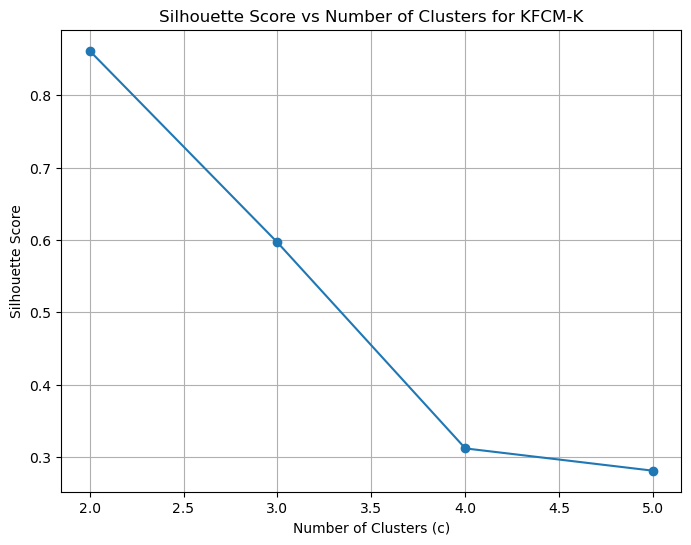

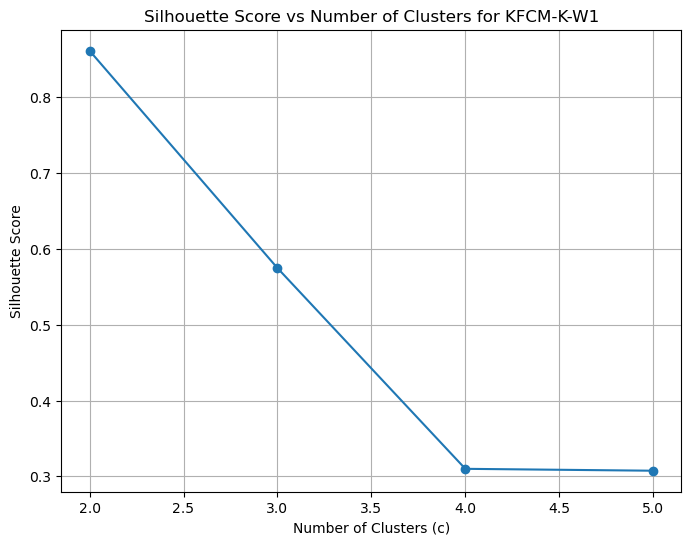

In [6]:
#KFCM-K
plot_silhouette_scores(results_kfcm_k, 'KFCM-K')
best_c_kfcm_k = max(results_kfcm_k['sil_scores'], key=results_kfcm_k['sil_scores'].get)

#KFCM-K-W.1
plot_silhouette_scores(results_kfcm_k_w_1, 'KFCM-K-W1')
best_c_kfcm_k_w_1 = max(results_kfcm_k_w_1['sil_scores'], key=results_kfcm_k_w_1['sil_scores'].get)


### Prototypes Plots

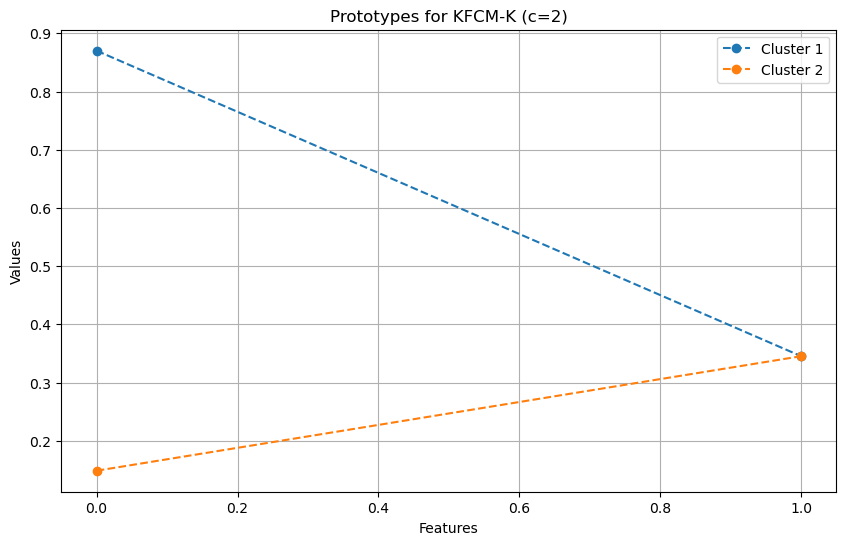


Prototypes for KFCM-K (c=2):
Prototype g1: [[0.87014333]
 [0.34522979]]
Prototype g2: [[0.14843012]
 [0.34522907]]


In [7]:
plot_prototypes(results_kfcm_k['prototypes'][best_c_kfcm_k], method_name='KFCM-K', c_value=best_c_kfcm_k)
display_prototypes(results_kfcm_k, best_c_kfcm_k, 'KFCM-K')

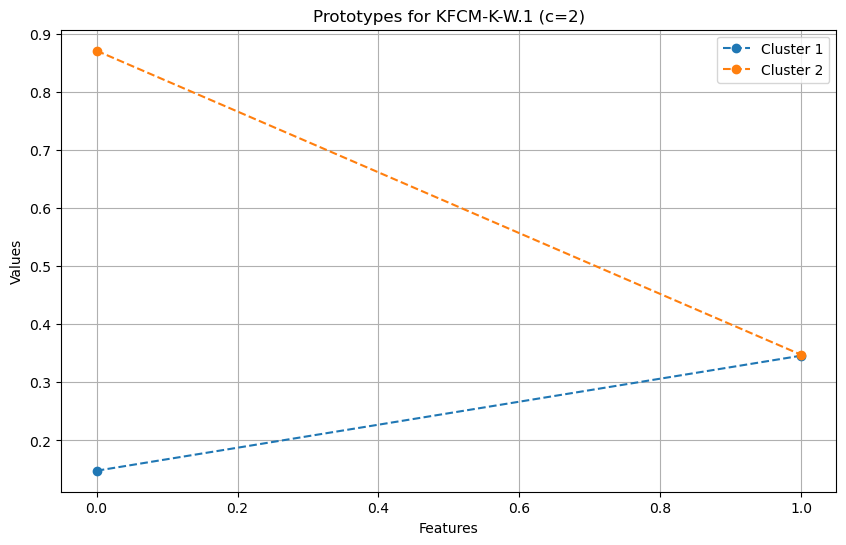


Prototypes for KFCM-K-W.1 (c=2):
Prototype g1: [[0.14785569]
 [0.34594834]]
Prototype g2: [[0.87094346]
 [0.3474846 ]]


In [8]:
plot_prototypes(results_kfcm_k_w_1['prototypes'][best_c_kfcm_k_w_1], method_name='KFCM-K-W.1', c_value=best_c_kfcm_k_w_1)
display_prototypes(results_kfcm_k_w_1, best_c_kfcm_k_w_1, 'KFCM-K-W.1')

In [9]:
#KFCM-K-W1
display_width_parameters(results_kfcm_k_w_1, best_c_kfcm_k_w_1, 'KFCM-K-W.1')


Width Parameters for KFCM-K-W.1 (c=2):
Width parameter s1: [[3.37570239]
 [0.29623464]]
Width parameter s2: [[2.59640479]
 [0.38514796]]


### Confusion Matrix


Confusion Matrix for KFCM-K (Crisp vs A Priori):


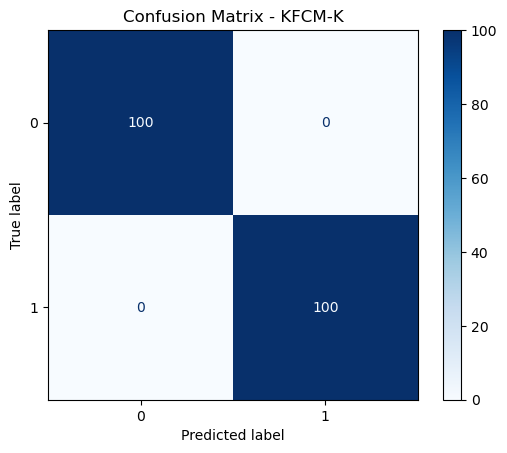

In [10]:
#KFCM-K
display_confusion_matrix(y, results_kfcm_k['best_fuzzy_partitions'][best_c_kfcm_k], 'KFCM-K')


Confusion Matrix for KFCM-K-W1 (Crisp vs A Priori):


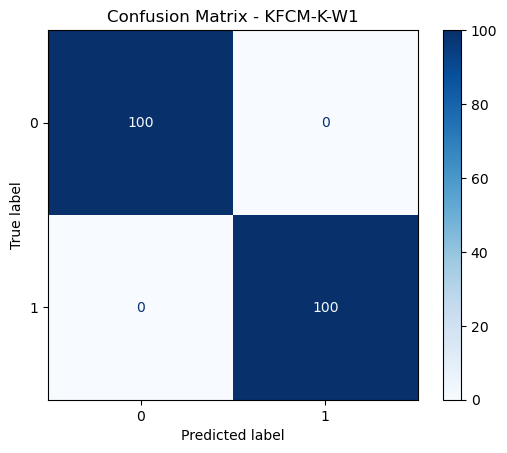

In [11]:
#KFCM-K-W1
display_confusion_matrix(y, results_kfcm_k_w_1['best_fuzzy_partitions'][best_c_kfcm_k_w_1], 'KFCM-K-W1')

### Objective Function History


Plotting Objective Function History for KFCM-K (c=2)


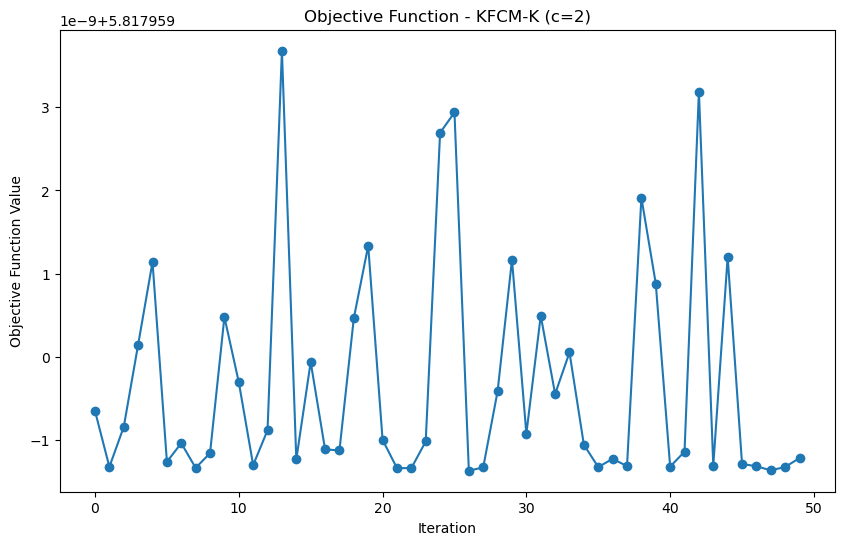

In [12]:
display_objective_function_history(results_kfcm_k, best_c_kfcm_k, 'KFCM-K')


Plotting Objective Function History for KFCM-K-W1 (c=2)


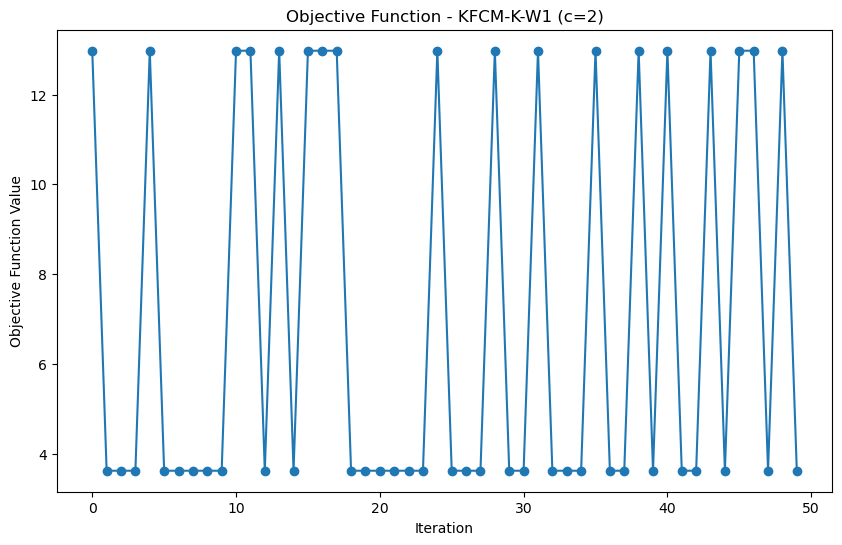

In [13]:
display_objective_function_history(results_kfcm_k_w_1, best_c_kfcm_k_w_1, 'KFCM-K-W1')